In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime

''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
from collections import Counter
import pandas as pd
import numpy as np

'''Classes for Reading in the Data and applying Internal Normalisation'''
from nu_data_reduction import NU_data_read, int_norm, evaluation, Neptune_data_read
from parameter import *
from dspike_formulas import *

import xlwings as xw
import openpyxl as oxl
import re
from openpyxl.utils.dataframe import dataframe_to_rows
import pylab as plt

In [28]:
path_template = "/Volumes/friebelm/PhD/Double Spike/Data Evaluation/"
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2017-10-03/"
path_sum = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2017-10-03/DS_inversion_excel/"

files_start = 8709
files_end = 8790 #8345

In [29]:
# Interference_corr on the denominator isotope
Te125_corr = True
# background correction
blk_corr = True

In [30]:
#wb = xw.Book(path + 'DS_template_117_122,124,118_xlw.xlsx')
#wb.sheets["Sheet1"].range('A1').value = df_all
#df_all_mean = df_all.drop("cycle", axis=1).groupby(df_all.index).mean()
#df_all_mean["sample"] = df_all[~df_all.index.duplicated(keep='first')]["sample"]
#wb.sheets["Sheet1"].range('A344').value = df_all_mean

In [31]:
def extract_metadata(filenumber, metadata_string):
    datafile = "Data_" + str(filenumber) + ".csv"

    df = pd.read_table(path + datafile, dtype=str, header=None)
    for row in range(len(df.index)):
        line = str(df[0][row])
        if metadata_string in line:
            metadata = re.search(r""+metadata_string+",(.*)", line).group(1)
    return metadata

In [32]:
columns_1 = ["cycle", "sample", "date", "H8 (1)", "H7 (1)", "H6 (1)", "H5 (1)", "H4 (1)", "H3 (1)", "H2 (1)", "H1 (1)", "Ax (1)", "L1 (1)", "L2 (1)", "L3 (1)", "L4 (1)"]
df_all = pd.DataFrame()
blk_ls = []
sample_ls = []
files_1 = range(files_start, files_end, 1)
#files_1 = range(5552,5623,1) + range(5632,5729, 1)

for sample in files_1:
    sample_name = extract_metadata(sample, "Sample Name")
    
    if sample_name == "blank sol" or sample_name == "wash" or sample_name == "wash clean" or sample_name == "Teflon blk":
        blk_ls.append(sample)
    elif sample_name == "SQ" or sample_name == "Teflon blk" or sample_name == "4ml HDPE blank":
        None
    else:
        sample_ls.append(sample)
        
    
    #wb.save(r'C:\path\to\new_file_name.xlsx')


In [33]:
for sample in sample_ls:
    
    sample_name = extract_metadata(sample, "Sample Name")
    Date = extract_metadata(sample, "Date")
    starttime = extract_metadata(sample, "Start Time") 
    datafile = "Data_" + str(sample) + ".csv"
    
    data_sample = pd.read_csv(path + datafile, skiprows=58, dtype=str, index_col='Cycle')
    
    # arbitrary blank positions - check blk position before and after sample 
    blk1 = [item for item in blk_ls if item < sample]
    blk2 = [item for item in blk_ls if item > sample]
    blk1 = blk1[-1]
    blk2 = blk2[0]
    blk_corr_sample = True #if True blank corr_activated
    
    wb = oxl.load_workbook(path_template + 'DS_template_117_122,124,118_xlw.xlsx')
    
    # Background correction
    if (blk_corr == True) and (blk_corr_sample == True):
        calc_param = wb["calc param"]
        data_sht = wb["DATA1"]
        
        calc_param['B17'].value = "On"
        
        datafile_blk_1 = "Data_" + str(blk1) + ".csv"
        blk_file_1 = pd.read_csv(path + datafile_blk_1,  skiprows=58, dtype=str, index_col='Cycle')
        sample_name_blk_1 = extract_metadata(blk1, "Sample Name")
        Date_blk_1 = extract_metadata(blk1, "Date")
        starttime_blk_1 = extract_metadata(blk1, "Start Time")
        
        datafile_blk_2 = "Data_" + str(blk2) + ".csv"
        blk_file_2 = pd.read_csv(path + datafile_blk_2,  skiprows=58, dtype=str, index_col='Cycle')
        sample_name_blk_2 = extract_metadata(blk2, "Sample Name")
        Date_blk_2 = extract_metadata(blk2, "Date")
        starttime_blk_2 = extract_metadata(blk2, "Start Time")
        
        data_sht['B3'].value = sample
        data_sht['B4'].value = Date
        data_sht['B5'].value = starttime
        data_sht['B6'].value = sample_name
        
        
        rows = dataframe_to_rows(data_sample)
        for r_idx, row in enumerate(rows, 11):
            for c_idx, value in enumerate(row, 1):
                 data_sht.cell(row=r_idx, column=c_idx, value=value)
        
        data_sht['B35'].value = blk1
        data_sht['B36'].value = Date_blk_1
        data_sht['B37'].value = starttime_blk_1
        data_sht['B38'].value = sample_name_blk_1        
        
        rows = dataframe_to_rows(blk_file_1)
        for r_idx, row in enumerate(rows, 43):
            for c_idx, value in enumerate(row, 1):
                 data_sht.cell(row=r_idx, column=c_idx, value=value)
        
        data_sht['B67'].value = blk2
        data_sht['B68'].value = Date_blk_2
        data_sht['B69'].value = starttime_blk_2
        data_sht['B70'].value = sample_name_blk_2
        
        rows = dataframe_to_rows(blk_file_2)
        for r_idx, row in enumerate(rows, 75):
            for c_idx, value in enumerate(row, 1):
                 data_sht.cell(row=r_idx, column=c_idx, value=value)
        
    else:
        calc_param = wb["calc param"]
        data_sht = wb["DATA1"]
        
        calc_param['B17'].value = "Off"
        
        datafile_blk_1 = "Data_" + str(blk1) + ".csv"
        blk_file_1 = pd.read_csv(path + datafile_blk_1,  skiprows=58, dtype=str, index_col='Cycle')
        sample_name_blk_1 = extract_metadata(blk1, "Sample Name")
        Date_blk_1 = extract_metadata(blk1, "Date")
        starttime_blk_1 = extract_metadata(blk1, "Start Time")
        
        datafile_blk_2 = "Data_" + str(blk2) + ".csv"
        blk_file_2 = pd.read_csv(path + datafile_blk_2,  skiprows=58, dtype=str, index_col='Cycle')
        sample_name_blk_2 = extract_metadata(blk2, "Sample Name")
        Date_blk_2 = extract_metadata(blk2, "Date")
        starttime_blk_2 = extract_metadata(blk2, "Start Time")
        
        data_sht['B3'].value = sample
        data_sht['B4'].value = Date
        data_sht['B5'].value = starttime
        data_sht['B6'].value = sample_name
        data_sht['A11'].value = data_sample
        
        data_sht['B35'].value = blk1
        data_sht['B36'].value = Date_blk_1
        data_sht['B37'].value = starttime_blk_1
        data_sht['B38'].value = sample_name_blk_1        
        data_sht['A43'].value = blk_file_1
        
        data_sht['B67'].value = blk2
        data_sht['B68'].value = Date_blk_2
        data_sht['B69'].value = starttime_blk_2
        data_sht['B70'].value = sample_name_blk_2
        data_sht['A75'].value = blk_file_2
        
    
    wb.save(path_sum + 'Data_'+ str(sample) +'_DS_inv_excel.xlsx')

In [126]:
wb_sum = xw.books.open(path_sum + '2017-09-20_summary_DS_Std_mix.xls')
wb_sum.activate
wb_sum_sht = wb_sum.sheets["DS_inv_summary"]


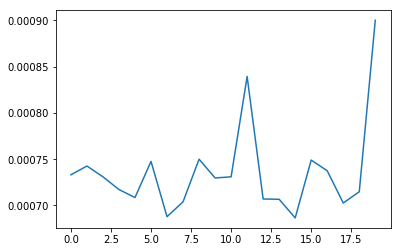

In [157]:
wb_file = xw.books.open(path_sum + 'Data_8388_DS_inv_excel.xlsx')
zero_sht = wb_file.sheets["ratio calc"]
blk_bgd_118 = zero_sht.range('D158:D177').value
plt.plot(blk_bgd_118)
plt.show()

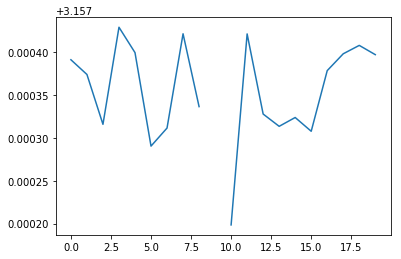

In [159]:
N_sht = wb_file.sheets["N"]
xN3r = N_sht.range('E4:E23').value
plt.plot(xN3r)
plt.show()

In [160]:
wb_sum_sht.range('E35').value = wb_file.sheets["DATA1"].range("B3").value
wb_sum_sht.range('F35').value = wb_file.sheets["DATA1"].range("B6").value

wb_sum_sht.range('G35').value = wb_file.sheets["N"].range("E65").value
wb_sum_sht.range('H35').value = wb_file.sheets["N"].range("E66").value
wb_sum_sht.range('I35').value = wb_file.sheets["N"].range("I65").value
wb_sum_sht.range('J35').value = wb_file.sheets["N"].range("I66").value
wb_sum_sht.range('K35').value = wb_file.sheets["N"].range("M65").value
wb_sum_sht.range('L35').value = wb_file.sheets["N"].range("M66").value

wb_sum_sht.range('N35').value = wb_file.sheets["eSn"].range("E65").value
wb_sum_sht.range('O35').value = wb_file.sheets["eSn"].range("E66").value
wb_sum_sht.range('Q35').value = wb_file.sheets["eSn"].range("I65").value
wb_sum_sht.range('R35').value = wb_file.sheets["eSn"].range("I66").value
wb_sum_sht.range('S35').value = wb_file.sheets["eSn"].range("M65").value
wb_sum_sht.range('T35').value = wb_file.sheets["eSn"].range("M66").value

wb_sum_sht.range('V35').value = wb_file.sheets["fnat"].range("E65").value
wb_sum_sht.range('W35').value = wb_file.sheets["fins"].range("E65").value

wb_sum_sht.range('Y35').value = wb_file.sheets["Conc. determ"].range("O6").value


In [107]:
for sample in sample_ls:
    
    sample_name = extract_metadata(sample, "Sample Name")
    Date = extract_metadata(sample, "Date")
    starttime = extract_metadata(sample, "Start Time")
    
    datafile = "Data_" + str(sample) + ".csv"
    data_sample = pd.read_csv(path + datafile, skiprows=58, dtype=str, index_col='Cycle')
    
    # arbitrary blank positions - check blk position before and after sample 
    blk1 = [item for item in blk_ls if item < sample]
    blk2 = [item for item in blk_ls if item > sample]
    blk1 = blk1[-1]
    blk2 = blk2[0]
    blk_corr_sample = True #if True blank corr_activated
    
    wb = xw.books.open(path_template + 'DS_template_117_122,124,118_xlw.xlsx')
    wb.activate
    
    # Background correction
    if (blk_corr == True) and (blk_corr_sample == True):
        calc_param = wb.sheets["calc param"]
        data_sht = wb.sheets["DATA1"]
        
        calc_param.range('B15').value = "On"
        
        datafile_blk_1 = "Data_" + str(blk1) + ".csv"
        blk_file_1 = pd.read_csv(path + datafile_blk_1,  skiprows=58, dtype=str, index_col='Cycle')
        sample_name_blk_1 = extract_metadata(blk1, "Sample Name")
        Date_blk_1 = extract_metadata(blk1, "Date")
        starttime_blk_1 = extract_metadata(blk1, "Start Time")
        
        datafile_blk_2 = "Data_" + str(blk2) + ".csv"
        blk_file_2 = pd.read_csv(path + datafile_blk_2,  skiprows=58, dtype=str, index_col='Cycle')
        sample_name_blk_2 = extract_metadata(blk2, "Sample Name")
        Date_blk_2 = extract_metadata(blk2, "Date")
        starttime_blk_2 = extract_metadata(blk2, "Start Time")
        
        data_sht.range('B3').value = sample
        data_sht.range('B4').value = Date
        data_sht.range('B5').value = starttime
        data_sht.range('B6').value = sample_name
        data_sht.range('A11').value = data_sample
        
        data_sht.range('B35').value = blk1
        data_sht.range('B36').value = Date_blk_1
        data_sht.range('B37').value = starttime_blk_1
        data_sht.range('B38').value = sample_name_blk_1        
        data_sht.range('A43').value = blk_file_1
        
        data_sht.range('B67').value = blk2
        data_sht.range('B68').value = Date_blk_2
        data_sht.range('B69').value = starttime_blk_2
        data_sht.range('B70').value = sample_name_blk_2
        data_sht.range('A75').value = blk_file_2
        
    else:
        calc_param = wb.sheets["calc param"]
        data_sht = wb.sheets["DATA1"]
        
        calc_param.range('B15').value = "Off"
        
        datafile_blk_1 = "Data_" + str(blk1) + ".csv"
        blk_file_1 = pd.read_csv(path + datafile_blk_1,  skiprows=58, dtype=str, index_col='Cycle')
        sample_name_blk_1 = extract_metadata(blk1, "Sample Name")
        Date_blk_1 = extract_metadata(blk1, "Date")
        starttime_blk_1 = extract_metadata(blk1, "Start Time")
        
        datafile_blk_2 = "Data_" + str(blk2) + ".csv"
        blk_file_2 = pd.read_csv(path + datafile_blk_2,  skiprows=58, dtype=str, index_col='Cycle')
        sample_name_blk_2 = extract_metadata(blk2, "Sample Name")
        Date_blk_2 = extract_metadata(blk2, "Date")
        starttime_blk_2 = extract_metadata(blk2, "Start Time")
        
        data_sht.range('B3').value = sample
        data_sht.range('B4').value = Date
        data_sht.range('B5').value = starttime
        data_sht.range('B6').value = sample_name
        data_sht.range('A11').value = data_sample
        
        data_sht.range('B35').value = blk1
        data_sht.range('B36').value = Date_blk_1
        data_sht.range('B37').value = starttime_blk_1
        data_sht.range('B38').value = sample_name_blk_1        
        data_sht.range('A43').value = blk_file_1
        
        data_sht.range('B67').value = blk2
        data_sht.range('B68').value = Date_blk_2
        data_sht.range('B69').value = starttime_blk_2
        data_sht.range('B70').value = sample_name_blk_2
        data_sht.range('A75').value = blk_file_2
        
    
    wb.save(path + 'Data_'+ str(sample) +'_DS_inv_excel.xlsx')


CommandError: Command failed:
		OSERROR: -1728
		MESSAGE: The object you are trying to access does not exist
		COMMAND: app(pid=5854).workbooks['DS_template_117_122,124,118_xlw.xlsx'].worksheets['calc param'].cells['B15'].first_row_index.get()

In [32]:
files_1 = range(files_start, files_end, 1)
df_raw_signals = pd.DataFrame()
df_DS_inv= pd.DataFrame()

for sample in sample_ls:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    
    # arbitrary blank positions - check blk position before and after sample 
    blk1 = [item for item in blk_ls if item < sample]
    blk2 = [item for item in blk_ls if item > sample]
    blk1 = blk1[-1]
    blk2 = blk2[0]
    blk_corr_sample = True #if True blank corr_activated
    
    # blank measurement surrounds sample
    #if ((sample-1) in blk_ls) and ((sample+1) in blk_ls):
    #    blk1 = sample-1
    #    blk2 = sample+1
    #    blk_corr_sample = True
    #else:
    #    blk_corr_sample = False
    
    # Background correction
    if (blk_corr == True) and (blk_corr_sample == True):
        # Reads signals of Blank measurements
        blk_1 = NU_data_read(path, blk1, cup_config)
        blk_2 = NU_data_read(path, blk2, cup_config)
        # Substracts baselines of signals
        df_zero = df.data_zero_corr(sample)
        df_bgd_1 = blk_1.data_zero_corr(blk1)
        df_bgd_2 = blk_2.data_zero_corr(blk2)   
        
        # Defines evaluation class with all evaluation methods present
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        # Outlier correction on signals of blank measurements
        df_bgd_1 = new_corr.mad_outlier_rejection_dict(df_bgd_1)
        df_bgd_2 = new_corr.mad_outlier_rejection_dict(df_bgd_2)
        # Background substraction of blank signals
        new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    
    # No background correction
    else:
        # Substracts baselines of signals
        df_zero = df.data_zero_corr(sample)
        # Defines evaluation class with all evaluation methods present
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
    
    # Gives zero_corrected Signals back & writes it in a dataframe
    data_sample_raw = new_corr.raw_signals(denom_isotope)
    data_sample_raw = pd.DataFrame.from_dict(data_sample_raw, orient = 'index')
    #data_sample_raw = new_corr.mad_outlier_rejection(data_sample_raw)
    
    #Get raw ratios
    data_sample = new_corr.raw_ratios(denom_isotope)
    # raw ratios from dataframe in dictionary for data handling
    data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
    data_sample_2 = pd.DataFrame.to_dict(data_sample)
    # First DS-inversion without interference correction
    data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_sample, spike_obj, Sn_mass_obj, spikeSn_ls , denom_isotope)
    data_spike_calc = data_spike_obj.dspike_corr(loop_nat, loop_ins, start_nat, start_ins, inv_iso_ratio)
    # Beta for interference correction
    beta = data_spike_calc["frac_ins_x2.5"]
    # Interference correction
    spike_corr = new_corr.norm_beta_to_raw("Sn", "117", beta)
    # interference corrected raw ratios
    data_corr_raw = pd.DataFrame.from_dict(spike_corr, orient = 'index')
    # Second DS-inversion
    data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_corr_raw, spike_obj, Sn_mass_obj, spikeSn_ls , denom_isotope)
    data_spike_calc_2 = data_spike_obj.dspike_corr(loop_nat, loop_ins, start_nat, start_ins, inv_iso_ratio)
    #Calculation of eSn
    data_spike_calc_2["eSn_118"] = ((data_spike_calc_2["Nr2:x"]/data_spike_calc_2["n0:x"])-1)*10000
    #Outlier rejection
    #data_spike_calc_2 = new_corr.mad_outlier_rejection(data_spike_calc_2)
    
    # Extraction of Sample Name, Date, Measurement time and add it to Dataframe
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_spike_calc_2["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_spike_calc_2["sample"] = sample_name
    data_spike_calc_2["cycle"] = data_sample.index.values
    
    data_sample_raw["cycle"] = data_sample_raw.index.values
    data_spike_calc_2 = data_spike_calc_2.merge(data_sample_raw)
    
    # Add each sample in for loop to a dataframe
    df_DS_inv = df_DS_inv.append(data_spike_calc_2)

In [15]:
#df_DS_inv = df_DS_inv.set_index("date")
columns = ["cycle", "sample", "eSn"]
columns.extend(df_DS_inv.drop(["cycle", "sample", "eSn_118"], axis=1).columns)
df_DS_inv_sub = pd.DataFrame(df_DS_inv, columns = columns)

#df_internal_sub["Cd/Sn"] = (df_internal_norm["111"]/12.722)/(df_internal_norm["118"]/24.223)
#df_internal_sub["Te/Sn"] = (df_internal_norm["125"]/7.0509)/(df_internal_norm["118"]/24.223)

#df_internal_sub["Te/Sn"] = (df_internal_norm["126"]/18.8066)/(df_internal_norm["118"]/24.223)
#df_internal_sub = df_internal_sub[df_internal_sub["118"] >= 7]
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")
df_DS_inv_sub 

,cycle,sample,eSn,n0:x,n0:y,n0:z,N0:x,N0:y,N0:z,a_nat0,...,b_ins2,c_ins2,Nr2:x,Nr2:y,Nr2:z,frac_nat_x2,122,124,118,117
date,,,,,,,,,,,,,,,,,,,,,
2017-09-15 19:15:00,1,DS-Sn-Wire Mix 20ppm 1,NaN,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,...,0.231725,-0.178054,3.157287,0.603463,0.753894,-0.018202,9.970815,1.959121,7.238530,12.172704
2017-09-15 19:15:00,2,DS-Sn-Wire Mix 20ppm 1,NaN,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,...,0.231713,-0.178045,3.157296,0.603471,0.753908,-0.017880,9.957975,1.956465,7.230245,12.159350
2017-09-15 19:15:00,3,DS-Sn-Wire Mix 20ppm 1,NaN,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,...,0.231730,-0.178059,3.157330,0.603504,0.753965,-0.016583,9.961169,1.957244,7.232076,12.162234
2017-09-15 19:15:00,4,DS-Sn-Wire Mix 20ppm 1,NaN,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,...,0.231739,-0.178066,3.157356,0.603528,0.754006,-0.015635,9.954552,1.956046,7.226117,12.152374
2017-09-15 19:15:00,5,DS-Sn-Wire Mix 20ppm 1,NaN,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,...,0.231706,-0.178039,3.157240,0.603418,0.753816,-0.019968,9.948305,1.954544,7.221846,12.144830
2017-09-15 19:15:00,6,DS-Sn-Wire Mix 20ppm 1,NaN,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,...,0.231711,-0.178043,3.157265,0.603443,0.753858,-0.019016,9.980287,1.960865,7.245207,12.184259
2017-09-15 19:15:00,7,DS-Sn-Wire Mix 20ppm 1,NaN,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,...,0.231738,-0.178065,3.157355,0.603527,0.754005,-0.015676,9.997425,1.964448,7.257441,12.205079
2017-09-15 19:15:00,8,DS-Sn-Wire Mix 20ppm 1,NaN,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,...,0.231716,-0.178047,3.157308,0.603483,0.753928,-0.017428,9.976815,1.960183,7.244284,12.182961
2017-09-15 19:15:00,9,DS-Sn-Wire Mix 20ppm 1,NaN,3.157776,0.603923,0.754692,3.155091,0.601399,0.750315,0.325587,...,0.231721,-0.178051,3.157296,0.603471,0.753908,-0.017878,10.047468,1.974147,7.294089,12.266472


In [257]:
def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = 2 * np.std(x)
    return SD2

df_DS_inv_mean = df_DS_inv_sub.drop("cycle", axis=1).groupby(df_DS_inv_sub.index).mean()
df_DS_inv_mean_sd = df_DS_inv_sub.drop("cycle", axis=1).groupby(df_DS_inv_sub.index).agg([np.mean, SD2])
df_DS_inv_mean["sample"] = df_DS_inv_sub[~df_DS_inv_sub.index.duplicated(keep='first')]["sample"]
df_DS_inv_mean_sd["sample"] = df_DS_inv_sub[~df_DS_inv_sub.index.duplicated(keep='first')]["sample"]
#df_internal_norm_mean_sd = df_internal_norm_mean_sd[1:8]
#df_internal_norm_mean = df_internal_norm_mean[df_internal_norm_mean["118"] >= 7]
df_DS_inv_mean_sd
#epsilon = epsilon.drop(["118"], axis = 1)
#plotplot = df_internal_norm_mean[(df_internal_norm_mean["125"] < 0.00010)  & (df_internal_norm_mean["124/120"] > 0.17745)] 
#plot(plotplot["125"], plotplot["124/120"], "ro")

eSn                n0:x           n0:y       \
                         mean       SD2      mean  SD2      mean  SD2   
date                                                                    
2017-09-15 19:15:00 -1.543107  0.237294  3.157776  0.0  0.603923  0.0   
2017-09-15 19:30:00 -1.592051  0.321143  3.157776  0.0  0.603923  0.0   
2017-09-15 19:45:00 -1.597194  0.273955  3.157776  0.0  0.603923  0.0   
2017-09-15 20:01:00 -1.655224  0.189087  3.157776  0.0  0.603923  0.0   
2017-09-15 20:17:00 -1.629283  0.257912  3.157776  0.0  0.603923  0.0   
2017-09-15 20:32:00 -1.591800  0.183977  3.157776  0.0  0.603923  0.0   
2017-09-15 20:48:00 -1.533054  0.302334  3.157776  0.0  0.603923  0.0   
2017-09-15 21:03:00 -1.696086  0.384589  3.157776  0.0  0.603923  0.0   
2017-09-15 21:19:00 -1.709669  0.339376  3.157776  0.0  0.603923  0.0   
2017-09-15 21:34:00 -1.726325  0.319277  3.157776  0.0  0.603923  0.0   
2017-09-15 21:50:00 -1.619621  0.251382  3.157776  0.0  0.603923  0.0   
2017-09-15 22:05:00 -1.645351  0.386365  3.157776  0.0  0.603923  0.0   
2017-09-15 22:21:00 -1.800923  0.360250  3.157776  0.0  0.603923  0.0   
2017-09-15 22:37:00 -1.838137  0.219285  3.157776  0.0  0.603923  0.0   
2017-09-15 22:52:00 -1.787655  0.404111  3.157776  0.0  0.603923  0.0   
2017-09-15 23:08:00 -1.698214  0.455921  3.157776  0.0  0.603923  0.0   
2017-09-15 23:23:00 -1.854084  0.295864  3.157776  0.0  0.603923  0.0   
2017-09-15 23:39:00 -1.673389  0.471800  3.157776  0.0  0.603923  0.0   
2017-09-15 23:54:00 -1.832802  0.378812  3.157776  0.0  0.603923  0.0   
2017-09-16 00:10:00 -1.630598  0.383632  3.157776  0.0  0.603923  0.0   
2017-09-16 00:25:00 -1.806561  0.209643  3.157776  0.0  0.603923  0.0   

                         n0:z                    N0:x                \
                         mean           SD2      mean           SD2   
date                                                                  
2017-09-15 19:15:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 19:30:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 19:45:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 20:01:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 20:17:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 20:32:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 20:48:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 21:03:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 21:19:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 21:34:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 21:50:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 22:05:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 22:21:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 22:37:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 22:52:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 23:08:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 23:23:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 23:39:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-15 23:54:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-16 00:10:00  0.754692  4.440892e-16  3.155091  2.664535e-15   
2017-09-16 00:25:00  0.754692  4.440892e-16  3.155091  2.664535e-15   

                              ...            frac_nat_x2       122            \
                              ...                    SD2      mean       SD2   
date                          ...                                              
2017-09-15 19:15:00           ...               0.002790  9.974423  0.027926   
2017-09-15 19:30:00           ...               0.003776  9.557871  0.061033   
2017-09-15 19:45:00           ...               0.003221  9.411849  0.118015   
2017-09-15 20:01:00           ...               0.002223  9.485451  0.065744   
2017-09-

In [258]:
df_DS_inv_mean_sample_sd = df_DS_inv_mean.groupby(df_DS_inv_mean["sample"]).agg([np.mean, SD2])
df_DS_inv_mean_sample_sd

eSn                n0:x           n0:y       \
                             mean       SD2      mean  SD2      mean  SD2   
sample                                                                      
DS-NIST Mix 1ppm opti.  -1.820027  0.046513  3.157776  0.0  0.603923  0.0   
DS-Sn-Wire Mix 100ppb 1 -1.662082  0.131156  3.157776  0.0  0.603923  0.0   
DS-Sn-Wire Mix 100ppb 2 -1.655474  0.083825  3.157776  0.0  0.603923  0.0   
DS-Sn-Wire Mix 20ppm 1  -1.577451  0.048750  3.157776  0.0  0.603923  0.0   
DS-Sn-Wire Mix 20ppm 2  -1.625435  0.052071  3.157776  0.0  0.603923  0.0   

                             n0:z                    N0:x         ...     \
                             mean           SD2      mean  SD2    ...      
sample                                                            ...      
DS-NIST Mix 1ppm opti.   0.754692  2.220446e-16  3.155091  0.0    ...      
DS-Sn-Wire Mix 100ppb 1  0.754692  0.000000e+00  3.155091  0.0    ...      
DS-Sn-Wire Mix 100ppb 2  0.754692  0.000000e+00  3.155091  0.0    ...      
DS-Sn-Wire Mix 20ppm 1   0.754692  2.220446e-16  3.155091  0.0    ...      
DS-Sn-Wire Mix 20ppm 2   0.754692  2.220446e-16  3.155091  0.0    ...      

                        frac_nat_x2                 122                 124  \
                               mean       SD2      mean       SD2      mean   
sample                                                                        
DS-NIST Mix 1ppm opti.    -0.021398  0.000547  9.671015  0.109981  1.977836   
DS-Sn-Wire Mix 100ppb 1   -0.019541  0.001542  5.999426  0.181321  2.421113   
DS-Sn-Wire Mix 100ppb 2   -0.019463  0.000986  6.090731  0.021499  2.462088   
DS-Sn-Wire Mix 20ppm 1    -0.018546  0.000573  9.648048  0.476714  1.896658   
DS-Sn-Wire Mix 20ppm 2    -0.019110  0.000612  9.473934  0.016630  1.858807   

                                        118                  117            
                              SD2      mean       SD2       mean       SD2  
sample                                                                      
DS-NIST Mix 1ppm opti.   0.022392  7.317815  0.079299  11.818000  0.127806  
DS-Sn-Wire Mix 100ppb 1  0.072193  9.218990  0.285743   7.700845  0.240114  
DS-Sn-Wire Mix 100ppb 2  0.009053  9.377114  0.031387   7.820499  0.025964  
DS-Sn-Wire Mix 20ppm 1   0.093376  6.998176  0.354260  11.766630  0.598936  
DS-Sn-Wire Mix 20ppm 2   0.003090  6.848651  0.015289  11.538035  0.026245  

[5 rows x 634 columns]

In [150]:
std_used = "NIST + DS opt. 0.6-0.4"
sub_index = df_DS_inv_mean[(df_DS_inv_mean["sample"].shift(1) == df_DS_inv_mean["sample"].shift(-1)) & (df_DS_inv_mean["sample"].shift(1) == std_used)].index
corr_values = df_DS_inv_mean[df_DS_inv_mean["124"] >= 0.1]
corr_values_2 = corr_values[corr_values["sample"].str.contains("opt")]
#corr_values_2 = corr_values[corr_values["sample"] == std_used]
#corr_values = df_internal_norm_mean
sample = corr_values["sample"]
sample_2 = corr_values_2["sample"]
std_mean = corr_values[(corr_values["sample"] == std_used)].mean()
new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

#std_mean["112/120", "114/120", "115/120", "117/120", "118/120", "119/120", "122/120", "124/120"] = [0.029823, 0.020189, 0.010372, 0.235299, 0.742923, 0.263443, 0.142078, 0.177546]
#print std_mean
#epsilon =  ((new / std_mean)-1)*10000
#new["sample"] = sample
epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*0.1
epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*0.1
epsilon_NIST["sample"] = sample
epsilon_2["sample"] = sample

epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
#epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
#epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"] != std_used]
epsilon_2 = epsilon_2[epsilon_2["sample"].str.contains("opt")]
#epsilon_2 = epsilon_2[epsilon_2["sample"] == std_used]
epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
#epsilon_comp.index = epsilon_comp["Date"]
#epsilon_comp.columns
epsilon_comp = epsilon_comp.sort_index(axis=0)

In [151]:
epsilon_NIST

,eSn,n0:x,n0:y,n0:z,N0:x,N0:y,N0:z,a_nat0,b_nat0,c_nat0,...,c_ins2,Nr2:x,Nr2:y,Nr2:z,frac_nat_x2,122,124,118,117,sample
date,,,,,,,,,,,,,,,,,,,,,


In [16]:
df_DS_inv_sub.to_csv(path + "DS_inv_no_bgd_corr_8303.csv")

In [259]:
df_DS_inv_mean_sd.to_csv(path + "DS_inv_bgd_corr.csv")

In [ ]:
df_Ds

In [68]:
# For one datapoint
files_1 = 7208

df = NU_data_read(path, sample, cup_config)
cycles = range(1, len(df.data_read(sample).index)+1)

# arbitrary blank positions
#blk1 = [item for item in blk_ls if item < sample]
#blk2 = [item for item in blk_ls if item > sample]
#blk1 = blk1[-1]
#blk2 = blk2[0]
#blk_corr_sample = True
    
if (blk_corr == True) and (blk_corr_sample == True):
    blk_1 = NU_data_read(path, blk1, cup_config)
    blk_2 = NU_data_read(path, blk2, cup_config)
    df_zero = df.data_zero_corr(sample)
    df_bgd_1 = blk_1.data_zero_corr(blk1)
    df_bgd_2 = blk_2.data_zero_corr(blk2)   
        
    new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
    df_bgd_1 = new_corr.mad_outlier_rejection_dict(df_bgd_1)
    df_bgd_2 = new_corr.mad_outlier_rejection_dict(df_bgd_2)
    df_bgd_corr = new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    #new_corr.line2_corr(df_bgd_corr, "119")
else:
    df_zero = df.data_zero_corr(sample)
    new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
    #new_corr.line2_corr(df_zero, "119")

data_sample = new_corr.raw_ratios(denom_isotope)
data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
df_zero

{'cycle1': {'Ax (1)': Counter({1: 0.00013836589999999954,
           2: 0.00012571850000000009,
           3: 0.00014383660000000069,
           4: 0.00014579099999999928,
           5: 0.00014788939999999841,
           6: 0.00014835819999999868,
           7: 0.00015420509999999887,
           8: 0.00015245509999999886,
           9: -4.0447400000000883e-05,
           10: 0.00014881189999999857,
           11: 0.00012035759999999909,
           12: 0.00014608449999999919,
           13: 0.00012900490000000014,
           14: 0.0003078537999999997,
           15: 0.00014112969999999919,
           16: 0.00014536620000000014,
           17: 0.00013632270000000016,
           18: 0.00014228219999999972,
           19: 0.00012344829999999876,
           20: 0.00012890919999999917}),
  'H1 (1)': Counter({1: 9.6512528109999991,
           2: 9.5990288110000002,
           3: 9.5930372110000004,
           4: 9.5689413110000014,
           5: 9.4110702110000002,
           6: 9.63697051100

In [69]:
#Spike Calculation uncorrected
data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_sample, spike_obj, Sn_mass_obj, spikeSn_ls , denom_isotope)
data_spike_calc = data_spike_obj.dspike_corr(3, 6, -0.1, -2, 'x')
beta = data_spike_calc["frac_ins_x2.5"]
beta

0    -1.510864
1    -1.508789
2    -1.508917
3    -1.506711
4    -1.505094
5    -1.511240
6    -1.512046
7    -1.509094
8     1.503680
9    -1.522139
10   -1.505025
11   -1.506463
12   -1.507148
13   -1.841712
14   -1.503643
15   -1.508317
16   -1.505471
17   -1.505653
18   -1.501966
19   -1.499314
Name: frac_ins_x2.5, dtype: float64

In [70]:
data_spike_calc

,n0:x,n0:y,n0:z,N0:x,N0:y,N0:z,a_nat0,b_nat0,c_nat0,m0.0:x,...,e_nat2,f_nat2,g_nat2,a_ins2,b_ins2,c_ins2,Nr2:x,Nr2:y,Nr2:z,frac_nat_x2
0,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619120,...,-4.404098,1.735338,-0.293320,0.251475,0.240988,-0.185533,3.157274,0.603449,0.753868,-0.018641
1,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619114,...,-4.403804,1.735305,-0.293300,0.251451,0.240961,-0.185511,3.157212,0.603391,0.753767,-0.020938
2,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619126,...,-4.403658,1.735289,-0.293290,0.251439,0.240954,-0.185506,3.157182,0.603362,0.753717,-0.022083
3,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619114,...,-4.403766,1.735301,-0.293297,0.251448,0.240956,-0.185507,3.157204,0.603383,0.753754,-0.021240
4,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619121,...,-4.403263,1.735245,-0.293264,0.251407,0.240918,-0.185476,3.157099,0.603284,0.753582,-0.025160
5,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619135,...,-4.403640,1.735287,-0.293289,0.251438,0.240958,-0.185509,3.157178,0.603358,0.753711,-0.022219
6,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619148,...,-4.403778,1.735302,-0.293298,0.251450,0.240974,-0.185522,3.157207,0.603385,0.753758,-0.021144
7,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619166,...,-4.403734,1.735297,-0.293295,0.251447,0.240975,-0.185523,3.157198,0.603377,0.753743,-0.021482
8,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.579143,...,-5.048140,1.804461,-0.335064,0.305595,0.271258,-0.210512,3.288068,0.736609,0.994117,4.753254
9,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619386,...,-4.399025,1.734778,-0.292982,0.251067,0.240709,-0.185304,3.156210,0.602448,0.752131,-0.058280


In [71]:
data_corr = {}
data_corr_raw = {}
cycle_no = 20
cycles = range(0, len(data_sample.index))

spike_corr = new_corr.norm_beta_to_raw("Sn", "117", beta)
    
    #data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')


In [72]:
spike_corr

{1: {'118': 0.61912006113889029,
  '122': 0.81813878936573747,
  '124': 0.16732120064277978},
 2: {'118': 0.61911425168525391,
  '122': 0.81805517367790703,
  '124': 0.1672851940216227},
 3: {'118': 0.61912628974194117,
  '122': 0.81805195573888878,
  '124': 0.1672793221099298},
 4: {'118': 0.61911404608763743,
  '122': 0.81798069012325936,
  '124': 0.16726362958883415},
 5: {'118': 0.61912080426918348,
  '122': 0.81790354598387227,
  '124': 0.16722271311813908},
 6: {'118': 0.61913509399426914,
  '122': 0.81813101822741197,
  '124': 0.16729994458236438},
 7: {'118': 0.61914757992317704,
  '122': 0.81816441621570202,
  '124': 0.16731911851154876},
 8: {'118': 0.61916617794426432,
  '122': 0.81805887151409529,
  '124': 0.16729603930839582},
 9: {'118': 0.5791433497747327,
  '122': 0.74595684179471722,
  '124': 0.16880522537091386},
 10: {'118': 0.6193856353460705,
  '122': 0.8182938239108356,
  '124': 0.16717424799163497},
 11: {'118': 0.61913683769205263,
  '122': 0.81790057198446653,


In [73]:
data_corr_raw = pd.DataFrame.from_dict(spike_corr, orient = 'index')

In [75]:
data_corr_raw

,122,124,118
1,0.818139,0.167321,0.619120
2,0.818055,0.167285,0.619114
3,0.818052,0.167279,0.619126
4,0.817981,0.167264,0.619114
5,0.817904,0.167223,0.619121
6,0.818131,0.167300,0.619135
7,0.818164,0.167319,0.619148
8,0.818059,0.167296,0.619166
9,0.745957,0.168805,0.579143
10,0.818294,0.167174,0.619386


In [79]:
data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_corr_raw, spike_obj, Sn_mass_obj, spikeSn_ls , denom_isotope)
data_spike_calc_2 = data_spike_obj.dspike_corr(3, 6, -0.1, -2.2, 'x')
data_spike_calc_2["eSn"] = ((data_spike_calc_2["Nr2:x"]/data_spike_calc_2["n0:x"])-1)*10000
data_spike_calc_2 = new_corr.mad_outlier_rejection(data_spike_calc_2)

In [80]:
data_spike_calc_2

,n0:x,n0:y,n0:z,N0:x,N0:y,N0:z,a_nat0,b_nat0,c_nat0,m0.0:x,...,f_nat2,g_nat2,a_ins2,b_ins2,c_ins2,Nr2:x,Nr2:y,Nr2:z,frac_nat_x2,eSn
0,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619120,...,1.735336,-0.293319,0.251475,0.240987,-0.185532,3.157272,0.603447,0.753864,-0.018726,-1.592763
1,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619114,...,1.735305,-0.293300,0.251451,0.240961,-0.185511,3.157213,0.603391,0.753768,-0.020908,-1.778381
2,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619126,...,1.735287,-0.293289,0.251438,0.240953,-0.185505,3.157179,0.603359,0.753712,-0.022195,-1.887829
3,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619114,...,1.735298,-0.293296,0.251446,0.240954,-0.185505,3.157199,0.603378,0.753745,-0.021441,-1.823652
4,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619121,...,1.735246,-0.293264,0.251407,0.240918,-0.185476,3.157099,0.603284,0.753582,-0.025148,-2.138903
5,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619135,...,1.735285,-0.293288,0.251437,0.240957,-0.185508,3.157175,0.603355,0.753705,-0.022338,-1.899962
6,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619148,...,1.735302,-0.293298,0.251450,0.240974,-0.185522,3.157207,0.603385,0.753757,-0.021152,-1.799092
7,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,0.619166,...,1.735297,-0.293295,0.251446,0.240975,-0.185522,3.157196,0.603375,0.753740,-0.021542,-1.832220
8,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3.157775,0.60392,0.754685,3.15509,0.601396,0.750308,0.325585,1.387874,-1.111603,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
data_spike_calc_2.to_csv(path+"test_2.csv")

eSn           n0:x          n0:y           n0:z  \
                            mean  SD2      mean  SD2     mean  SD2      mean   
sample                                                                         
DS-NIST Mix 1ppm opti. -1.803065  0.0  3.157775  0.0  0.60392  0.0  0.754685   

                                N0:x      ...  frac_nat_x2            122  \
                        SD2     mean  SD2 ...         mean  SD2      mean   
sample                                    ...                               
DS-NIST Mix 1ppm opti.  0.0  3.15509  0.0 ...    -0.021199  0.0  9.636478   

                                  124            118             117       
                        SD2      mean  SD2      mean  SD2       mean  SD2  
sample                                                                     
DS-NIST Mix 1ppm opti.  0.0  1.971941  0.0  7.302154  0.0  11.789357  0.0  

[1 rows x 634 columns]